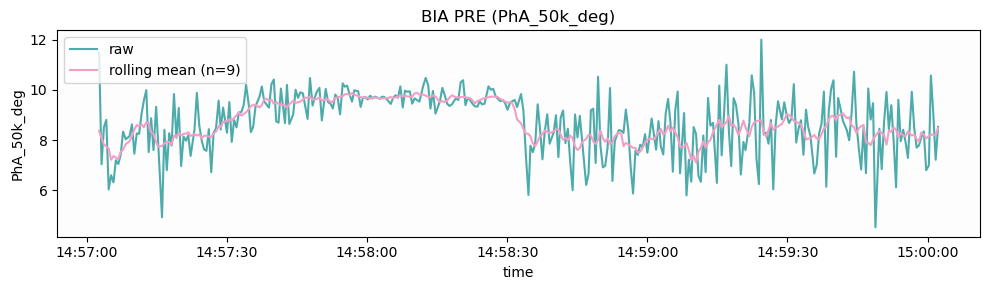

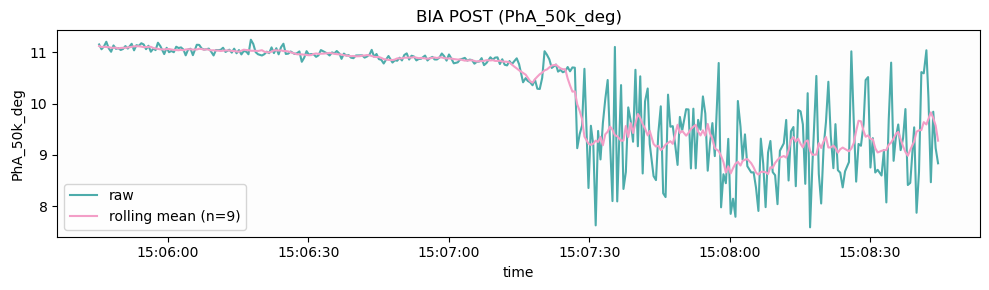


VARIABLES À UTILISER
- bia_pre   : DataFrame PRE (colonnes: time, PhA_50k_deg, etc.)
- bia_post  : DataFrame POST (colonnes: time, PhA_50k_deg, etc.)
- pha_pre   : numpy array, PhA_50k_deg sur PRE
- pha_post  : numpy array, PhA_50k_deg sur POST
- t_pre     : numpy array, temps (s) relatif au début de PRE
- t_post    : numpy array, temps (s) relatif au début de POST
- fs_pre_est  : float, fs approx PRE (= 1 / dt_médian)
- fs_post_est : float, fs approx POST (= 1 / dt_médian)


In [7]:

# BIA RAW IMPORT -> PhA_50k -> PRE/POST WINDOWS -> OUTPUT VARS
# RAW, NO FILTERING / NO RESAMPLING IMPOSED

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, freqz, welch
from numpy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from mpl_toolkits.mplot3d import Axes3D


#==================================================================================
# LOAD DATA, PROCESS BIA, CREATE WINDOWS
#==================================================================================

# CONFIG 

BIA_PKL_PATH = "../data/LEA_BIA_RAW.pkl"   # pkl file exported from BIA device (raw data for pandas)
FREQ_COL = "f_48800"              # ~50 kHz complex impedance column

# Window timestamps (BIA datetime): 3 minutes BEFORE / fatigue inducing protocole / and 3 minutes AFTER
PRE_START_TIME  = "2025-11-28 14:57:02.563"
PRE_END_TIME    = "2025-11-28 15:00:02.563"
POST_START_TIME = "2025-11-28 15:05:45.278"
POST_END_TIME   = "2025-11-28 15:08:44.534"


# LOAD RAW BIA (.pkl)
data_bia_raw = pd.read_pickle(BIA_PKL_PATH)


# ANALYSIS DATAFRAME (same data, cleaner columns)
data_bia = data_bia_raw.copy()

# Parse time
data_bia["time"] = pd.to_datetime(data_bia["timestamp"], errors="coerce")
data_bia = data_bia.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# Complex impedance at ~50 kHz
data_bia["Z_50k"] = data_bia[FREQ_COL].astype(np.complex128)

# Compute R, Xc, PhA (standard convention: Xc = -imag(Z))
data_bia["R_50k_ohm"]   = np.real(data_bia["Z_50k"])
data_bia["Xc_50k_ohm"]  = -np.imag(data_bia["Z_50k"])
data_bia["PhA_50k_deg"] = np.degrees(np.arctan2(data_bia["Xc_50k_ohm"], data_bia["R_50k_ohm"]))

# Compact analysis view
analysis_cols = ["time", "Z_50k", "R_50k_ohm", "Xc_50k_ohm", "PhA_50k_deg", "sat", "min", "max"]
data_bia_analysis = data_bia[analysis_cols].copy()

# CREATE WINDOWS (PRE / POST)

pre_start  = pd.to_datetime(PRE_START_TIME)
pre_end    = pd.to_datetime(PRE_END_TIME)
post_start = pd.to_datetime(POST_START_TIME)
post_end   = pd.to_datetime(POST_END_TIME)

def slice_window(df, t0, t1):
    m = (df["time"] >= t0) & (df["time"] <= t1)  # inclusive bounds [start, end]
    return df.loc[m].copy()

bia_pre  = slice_window(data_bia_analysis, pre_start, pre_end)
bia_post = slice_window(data_bia_analysis, post_start, post_end)


#  PLOTS (just for verification)

def plot_window(df_win, title, y_col="PhA_50k_deg", smooth_n=9):
    if len(df_win) < 5:
        print("Not enough points to plot:", title)
        return
    d = df_win.copy()
    d["time"] = pd.to_datetime(d["time"])
    d = d.sort_values("time")
    y = pd.to_numeric(d[y_col], errors="coerce")
    y_sm = y.rolling(smooth_n, center=True, min_periods=1).mean()

    plt.figure(figsize=(10,3))
    plt.plot(d["time"], y, alpha=0.7, label="raw", color="#028A88")  # teal
    plt.plot(d["time"], y_sm, label=f"rolling mean (n={smooth_n})", color="#F39EC7")  # pink
    plt.title(title, color="#000000")
    plt.xlabel("time", color="#000000")
    plt.ylabel(y_col, color="#000000")
    plt.gca().set_facecolor("#FDFDFD")  # light background
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_window(bia_pre,  "BIA PRE (PhA_50k_deg)")
plot_window(bia_post, "BIA POST (PhA_50k_deg)")


# OUTPUT (variables to use)

pha_pre  = bia_pre["PhA_50k_deg"].astype(float).dropna().to_numpy()
pha_post = bia_post["PhA_50k_deg"].astype(float).dropna().to_numpy()

t_pre  = (bia_pre["time"]  - bia_pre["time"].iloc[0]).dt.total_seconds().to_numpy()
t_post = (bia_post["time"] - bia_post["time"].iloc[0]).dt.total_seconds().to_numpy()

dt_pre_med  = float(bia_pre["time"].diff().dt.total_seconds().median())
dt_post_med = float(bia_post["time"].diff().dt.total_seconds().median())
fs_pre_est  = 1.0 / dt_pre_med
fs_post_est = 1.0 / dt_post_med

print("\nVARIABLES À UTILISER")
print("- bia_pre   : DataFrame PRE (colonnes: time, PhA_50k_deg, etc.)")
print("- bia_post  : DataFrame POST (colonnes: time, PhA_50k_deg, etc.)")
print("- pha_pre   : numpy array, PhA_50k_deg sur PRE")
print("- pha_post  : numpy array, PhA_50k_deg sur POST")
print("- t_pre     : numpy array, temps (s) relatif au début de PRE")
print("- t_post    : numpy array, temps (s) relatif au début de POST")
print("- fs_pre_est  : float, fs approx PRE (= 1 / dt_médian)")
print("- fs_post_est : float, fs approx POST (= 1 / dt_médian)")



In [ ]:
#=================================================================================
#Stochastic Process ANALYSIS
#=================================================================================

# ----------
# Global config 
# ----------

Y_COL = "PhA_50k_deg"

# We regularize the time grid because ACF/AR assume equally spaced samples.
RESAMPLE_RULE = "500ms" # 500 ms is close to the observed median dt (~0.513 s) in your windows.

# Lags used for ACF/PACF plots:
PLOT_LAGS = 40 # 40 lags at 0.5 s -> ~20 s horizon (enough to see medium-term dependence).

# Residual whiteness test horizon:
LB_LAG = 20 # 20 lags at 0.5 s -> ~10 s horizon (short-to-medium memory check).

# Candidate AR orders upper bound (clipped further by n//10 below).
P_MAX_CAP = 20
# Significance level for residual whiteness decision.
ALPHA = 0.05

# ----------
# Stochastic Process tools
# ----------
class Stochastic_Process:
    def prep_series(df_win, y_col=Y_COL, resample_rule=RESAMPLE_RULE):
        """
        Prepare a clean 1D series for time-series tools (ACF/AR):
        - parse/sort timestamps
        - keep the signal as numeric
        - regularize sampling (resample + interpolate) to enforce equal spacing

        Returns:
        y_out : pd.Series indexed by time
        info  : small dict (n, dt medians, start/end) for traceability
        """
        d = df_win[["time", y_col]].copy()
        d["time"] = pd.to_datetime(d["time"], errors="coerce")
        d = d.dropna(subset=["time"]).sort_values("time").set_index("time")

        y = pd.to_numeric(d[y_col], errors="coerce")

        # Raw dt (before resampling)
        dt_raw = d.index.to_series().diff().dt.total_seconds().dropna()
        dt_raw_med = float(dt_raw.median()) if len(dt_raw) else np.nan

        if resample_rule is None:
            # If raw dt is already regular enough, keep raw sampling
            y_out = y.dropna()
            dt_out = y_out.index.to_series().diff().dt.total_seconds().dropna()
        else:
            # Regular grid -> helps make ACF/AR assumptions explicit
            y_out = y.resample(resample_rule).mean().interpolate("time")
            dt_out = y_out.index.to_series().diff().dt.total_seconds().dropna()

        info = {
            "start": d.index.min(),
            "end": d.index.max(),
            "n_raw": int(y.notna().sum()),
            "n_out": int(y_out.notna().sum()),
            "dt_raw_med_s": dt_raw_med,
            "dt_out_med_s": float(dt_out.median()) if len(dt_out) else np.nan,
            "resample_rule": resample_rule,
        }
        return y_out, info

    def plot_series_acf_pacf(y, name, plot_lags=PLOT_LAGS):
        # 1) Series
        plt.figure(figsize=(10, 3))
        plt.plot(y.index, y.values, color="#028A88")
        plt.title(f"{name} | {Y_COL} (prepared)", color="#028A88")
        plt.xlabel("time", color="#028A88")
        plt.ylabel(Y_COL, color="#028A88")
        plt.gca().set_facecolor("#E2E7EB")
        plt.tight_layout()
        plt.show()

        # Compute ACF / PACF explicitly
        acf_vals = acf(y.dropna(), nlags=plot_lags, fft=True)
        pacf_vals = pacf(y.dropna(), nlags=plot_lags, method="ywm")

        lags = np.arange(1, plot_lags + 1)

        # 2) ACF (exclude lag 0)
        plt.figure(figsize=(8, 3))
        plt.stem(lags, acf_vals[1:], basefmt=" ", linefmt="#028A88", markerfmt="#028A88o")
        plt.axhline(0, color="#028A88", linewidth=0.8)
        plt.axhspan(
            -1.96 / np.sqrt(len(y)),
            1.96 / np.sqrt(len(y)),
            alpha=0.2,
            color="#F39EC7"
        )
        plt.title(f"{name} | ACF (lags 1–{plot_lags})", color="#028A88")
        plt.xlabel("lag", color="#028A88")
        plt.gca().set_facecolor("#E2E7EB")
        plt.tight_layout()
        plt.show()

        # 3) PACF (exclude lag 0)
        plt.figure(figsize=(8, 3))
        plt.stem(lags, pacf_vals[1:], basefmt=" ", linefmt="#028A88", markerfmt="#028A88o")
        plt.axhline(0, color="#028A88", linewidth=0.8)
        plt.axhspan(
            -1.96 / np.sqrt(len(y)),
            1.96 / np.sqrt(len(y)),
            alpha=0.2,
            color="#F39EC7"
        )
        plt.title(f"{name} | PACF (lags 1–{plot_lags})", color="#028A88")
        plt.xlabel("lag", color="#028A88")
        plt.gca().set_facecolor("#E2E7EB")
        plt.tight_layout()
        plt.show()
    
    def stationarity_tests(y):
        """
        Two complementary tests:
        - ADF: H0 = unit root (non-stationary). Small p -> reject non-stationarity.
        - KPSS: H0 = stationary. Small p -> reject stationarity.

        Using both helps avoid a one-test-only decision.
        """
        yv = pd.Series(y).dropna().to_numpy()

        # ADF (autolag chooses lag length via AIC internally)
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(yv, autolag="AIC")

        # KPSS can warn when p-value is below available table -> interpret as p < 0.01
        try:
            kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")
        except Exception:
            kpss_stat, kpss_p, kpss_crit = np.nan, np.nan, None

        return {
            "adf_stat": float(adf_stat),
            "adf_p": float(adf_p),
            "adf_crit": adf_crit,
            "kpss_stat": float(kpss_stat) if np.isfinite(kpss_stat) else np.nan,
            "kpss_p": float(kpss_p) if np.isfinite(kpss_p) else np.nan,
            "kpss_crit": kpss_crit,
        }


    def print_stationarity(st, name):
        print(f"\n{name} | stationarity tests")
        print(f"ADF : stat={st['adf_stat']:.3f} | p={st['adf_p']:.4f}")
        if np.isfinite(st["kpss_stat"]):
            if st["kpss_p"] <= 0.01:
                print(f"KPSS: stat={st['kpss_stat']:.3f} | p<0.01")
            else:
                print(f"KPSS: stat={st['kpss_stat']:.3f} | p={st['kpss_p']:.4f}")
        else:
            print("KPSS: NA (series too short or nearly constant)")

    def ar_grid_search(y_fit, p_max_cap=P_MAX_CAP):
        """
        Fit AR(p) for p=1..p_max and report best AIC and best BIC
        cap p to avoid overfitting on short windows
        """
        yv = pd.Series(y_fit).dropna()
        n = len(yv)
        p_max = max(1, min(p_max_cap, n // 10))  # conservative rule

        best_aic = None
        best_bic = None

        for p in range(1, p_max + 1):
            try:
                m = AutoReg(yv, lags=p, old_names=False).fit()
            except Exception:
                continue

            if (best_aic is None) or (m.aic < best_aic.aic):
                best_aic = m
            if (best_bic is None) or (m.bic < best_bic.bic):
                best_bic = m

        if best_aic is None or best_bic is None:
            raise RuntimeError("AR grid search failed (try smaller p_max_cap).")

        return {
            "p_max_used": p_max,
            "model_aic": best_aic,
            "p_aic": int(best_aic.model._maxlag),
            "model_bic": best_bic,
            "p_bic": int(best_bic.model._maxlag),
        }


    def choose_p_by_whiteness(y_fit, p_max_cap=P_MAX_CAP, lb_lag=LB_LAG, alpha=ALPHA):
        """
        choose the smallest p such that Ljung-Box p-value > alpha.
        If none passes, fall back to best-BIC (+report the limitation).
        """
        yv = pd.Series(y_fit).dropna()
        n = len(yv)
        p_max = max(1, min(p_max_cap, n // 10))

        rows = []
        models = {}

        for p in range(1, p_max + 1):
            try:
                m = AutoReg(yv, lags=p, old_names=False).fit()
                resid = pd.Series(m.resid).dropna()

                lb = acorr_ljungbox(resid, lags=[lb_lag], return_df=True)
                lb_p = float(lb["lb_pvalue"].iloc[0])

                rows.append((p, float(m.aic), float(m.bic), lb_p))
                models[p] = m
            except Exception:
                continue

        scan = pd.DataFrame(rows, columns=["p", "AIC", "BIC", f"LB_p_lag{lb_lag}"]).sort_values("p")

        ok = scan[scan[f"LB_p_lag{lb_lag}"] > alpha]
        if len(ok):
            p_star = int(ok.iloc[0]["p"])
            return {"p": p_star, "model": models[p_star], "passed": True, "p_max_used": p_max}
        else:
            # fallback: best BIC among scanned models
            p_bic = int(scan.loc[scan["BIC"].idxmin(), "p"])
            return {"p": p_bic, "model": models[p_bic], "passed": False, "p_max_used": p_max}


    def residual_diagnostics(model, name, lb_lag=LB_LAG, plot_lags=PLOT_LAGS):
        """
        Minimal diagnostics:
        - Residual ACF (visual) excluding lag 0 (trivially = 1)
        - Ljung-Box p-value at fixed lag (statistical)
        """
        resid = pd.Series(model.resid).dropna()

        # Compute residual ACF explicitly to drop lag 0 from the plot. see before notes (it does skew the view here as well, since the scale is dominated by lag 0).
        acf_vals = acf(resid.to_numpy(), nlags=plot_lags, fft=True)
        lags = np.arange(1, plot_lags + 1)

        plt.figure(figsize=(8, 3))
        plt.stem(lags, acf_vals[1:], basefmt=" ", linefmt="#028A88", markerfmt="#028A88o")
        plt.axhline(0, color="#028A88", linewidth=0.8)
        plt.axhspan(
            -1.96 / np.sqrt(len(y)),
            1.96 / np.sqrt(len(y)),
            alpha=0.2,
            color="#F39EC7"
        )
        plt.title(f"{name} | ACF (lags 1–{plot_lags})", color="#028A88")
        plt.xlabel("lag", color="#028A88")
        plt.gca().set_facecolor("#E2E7EB")
        plt.tight_layout()
        plt.show()

        # simple approx CI band (same idea as statsmodels' default)
        ci = 1.96 / np.sqrt(len(resid))
        plt.axhspan(-ci, ci, alpha=0.2)

        plt.title(f"{name} | Residual ACF (lags 1–{plot_lags})")
        plt.xlabel("lag")
        plt.tight_layout()
        plt.show()

        # Ljung-Box whiteness test at a fixed horizon
        lb = acorr_ljungbox(resid, lags=[lb_lag], return_df=True)
        lb_p = float(lb["lb_pvalue"].iloc[0])

        return {
            "lb_p": lb_p,
            "resid_var": float(np.var(resid, ddof=1)),
        }



    def run_ar_block(y_fit, name, diff_used):
        """
        One window (PRE or POST):
        - report best AIC and best BIC AR(p)
        - pick final p by whiteness 
        - report a small set of parameters
        - residual diagnostics
        """
        print(f"\n {name} | AR modeling")
        print(f"Series used: diff1={diff_used} | n={len(y_fit)}")

        grid = Stochastic_Process.ar_grid_search(y_fit)
        print(f"AR grid search: p_max_used={grid['p_max_used']}")
        print(f"Best by AIC: p={grid['p_aic']} | AIC={grid['model_aic'].aic:.3f} | BIC={grid['model_aic'].bic:.3f}")
        print(f"Best by BIC: p={grid['p_bic']} | AIC={grid['model_bic'].aic:.3f} | BIC={grid['model_bic'].bic:.3f}")

        chosen = Stochastic_Process.choose_p_by_whiteness(y_fit)
        final_p = chosen["p"]
        final_model = chosen["model"]

        if chosen["passed"]:
            print(f"Final AR(p) chosen by whiteness: p={final_p}")
        else:
            print(f"Final AR(p): no p<=p_max achieved Ljung-Box p>{ALPHA} at lag={LB_LAG}.")
            print(f"Using best-BIC fallback: p={final_p}")
            print("Note: remaining autocorrelation suggests ARMA may be more appropriate.")

        # Minimal parameter report (enough for the assignment)
        print("Params (head):")
        print(final_model.params.head(6))

        diag = Stochastic_Process.residual_diagnostics(final_model, name)

        print(f"Ljung-Box (lag={LB_LAG}): p={diag['lb_p']:.4f}")

        return {
            "name": name,
            "diff1": diff_used,
            "p_aic": grid["p_aic"],
            "p_bic": grid["p_bic"],
            "p_final": int(final_p),
            "aic_final": float(final_model.aic),
            "bic_final": float(final_model.bic),
            "lb_p": diag["lb_p"],
            "resid_var": diag["resid_var"],
        }

In [22]:

#==================================================================================
# SPECTRAL ANALYSIS FUNCTIONS
#==================================================================================
class SpectralAnalysis:
    
    def butter_lowpass_filter(data, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def plot_butter_lowpass_filter(data, cutoff, fs, order=5):
        """
        Plot Butterworth lowpass filter response
    
        Parameters:
        - data: Input signal
        - cutoff: Cutoff frequency (Hz)
        - fs: Sampling frequency (Hz)
        - order: Filter order
        """
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        w, h = freqz(b, a, worN=8000)
    
        plt.figure(figsize=(10, 4))
        plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
        plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
        plt.axvline(cutoff, color='k')
        plt.title(f"Butterworth Lowpass Filter (order={order})")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_power_spectrum(freqs, power, title):
        """
        Plot power spectrum
    
        Parameters:
        - freqs: Frequency vector
        - power: Power spectrum
        - title: Plot title
        """
        plt.figure(figsize=(10, 4))
        plt.semilogy(freqs, power)
        plt.title(title)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    
    def compute_fft_power_spectrum(signal, fs, window='hann'):
        """
        Compute FFT power spectrum
    
        Parameters:
        - signal: Input signal (preprocessed)
        - fs: Sampling frequency (Hz)
        - window: Window function ('hann', 'hamming', or None)
    
        Returns:
        - freqs: Frequency vector (0 to Nyquist)
        - power: Power spectrum
        """
        n = len(signal)
    
        # Apply window
        if window == 'hann':
            win = np.hanning(n)
        elif window == 'hamming':
            win = np.hamming(n)
        else:
            win = np.ones(n)
    
        signal_windowed = signal * win
    
        # FFT
        fft_vals = rfft(signal_windowed)
        freqs = rfftfreq(n, d=1.0/fs)
    
        # Power spectrum (normalized by window energy)
        power = (np.abs(fft_vals) ** 2) / (np.sum(win**2) / n)
    
        return freqs, power
    def plot_fft_power_spectrum(signal, fs, title, window='hann'):
            """
            Compute and plot FFT power spectrum
        
            Parameters:
            - signal: Input signal (preprocessed)
            - fs: Sampling frequency (Hz)
            - title: Plot title
            - window: Window function ('hann', 'hamming', or None)
            """
            freqs, power = SpectralAnalysis.compute_fft_power_spectrum(signal, fs, window)
            SpectralAnalysis.plot_power_spectrum(freqs, power, title)

In [23]:
#==================================================================================
# FRACTAL ANALYSIS FUNCTIONS
#==================================================================================

class fractal_analysis:
    def fractal_dimension_boxcount(signal, time_vector=None):
        """
        Compute fractal dimension using box-counting method
        
        The signal is treated as a 2D curve (t, signal(t)) and covered with boxes
        of decreasing size to estimate the fractal dimension.
        
        Parameters:
        - signal: 1D array of signal values
        - time_vector: Optional time vector (if None, uses indices)
        
        Returns:
        - D: Fractal dimension estimate
        - box_sizes: Array of box sizes used
        - counts: Array of box counts
        """
        # Normalize signal to [0, 1] for numerical stability
        signal_norm = (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-10)
        
        if time_vector is None:
            time_vector = np.arange(len(signal))
        
        # Normalize time to [0, 1]
        time_norm = (time_vector - np.min(time_vector)) / (np.max(time_vector) - np.min(time_vector) + 1e-10)
        
        # Create 2D representation of the signal
        # Points: (time_norm[i], signal_norm[i])
        
        # Define range of box sizes (logarithmically spaced)
        n_points = len(signal)
        min_boxes = 4
        max_boxes = min(n_points // 2, 1000)
        
        # Number of boxes in one dimension (we'll use square boxes)
        n_divisions = np.logspace(np.log10(min_boxes), np.log10(max_boxes), num=20, dtype=int)
        n_divisions = np.unique(n_divisions)
        
        box_counts = []
        box_sizes = []
        
        for n_div in n_divisions:
            # Box size in normalized space
            box_size = 1.0 / n_div
            box_sizes.append(box_size)
            
            # Discretize points into boxes
            box_indices_x = (time_norm / box_size).astype(int)
            box_indices_y = (signal_norm / box_size).astype(int)
            
            # Clip to valid range
            box_indices_x = np.clip(box_indices_x, 0, n_div - 1)
            box_indices_y = np.clip(box_indices_y, 0, n_div - 1)
            
            # Count unique boxes occupied
            occupied_boxes = set(zip(box_indices_x, box_indices_y))
            box_counts.append(len(occupied_boxes))
        
        box_sizes = np.array(box_sizes)
        box_counts = np.array(box_counts)
        
        # Fit log(N) vs log(1/ε)
        # N(ε) ~ ε^(-D) => log(N) = -D * log(ε) + const
        log_box_sizes = np.log(box_sizes)
        log_counts = np.log(box_counts)
        
        # Linear regression
        coeffs = np.polyfit(log_box_sizes, log_counts, 1)
        D = -coeffs[0]  # Negative slope = fractal dimension
        
        return D, box_sizes, box_counts
    def plot_fractal_dimension(signal, time_vector=None):
        """
        Plot box-counting results for fractal dimension estimation
        
        Parameters:
        - signal: 1D array of signal values
        - time_vector: Optional time vector (if None, uses indices)
        """
        D, box_sizes, box_counts = fractal_analysis.fractal_dimension_boxcount(signal, time_vector)
        
        log_box_sizes = np.log(box_sizes)
        log_counts = np.log(box_counts)
        
        plt.figure(figsize=(8, 5))
        plt.scatter(log_box_sizes, log_counts, label='Data points')
        
        # Fit line
        coeffs = np.polyfit(log_box_sizes, log_counts, 1)
        fit_line = np.polyval(coeffs, log_box_sizes)
        
        plt.plot(log_box_sizes, fit_line, color='red', label=f'Fit line (D={-coeffs[0]:.3f})')
        
        plt.title('Fractal Dimension Estimation (Box-Counting)')
        plt.xlabel('log(Box Size ε)')
        plt.ylabel('log(Box Count N(ε))')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def dfa_analysis(signal, min_scale=4, max_scale=None, num_scales=20):
        """
        Perform Detrended Fluctuation Analysis (DFA)
        
        Algorithm:
        1. Integrate the signal (cumulative sum after removing mean)
        2. Divide into non-overlapping windows of size n
        3. Fit a polynomial trend in each window and calculate residuals
        4. Calculate RMS fluctuation F(n) for each window size
        5. Plot log(F(n)) vs log(n) → slope = scaling exponent α
        
        Parameters:
        - signal: 1D array
        - min_scale: Minimum window size
        - max_scale: Maximum window size (default: len(signal)//4)
        - num_scales: Number of scales to analyze
        
        Returns:
        - alpha: DFA scaling exponent
        - scales: Array of window sizes
        - fluctuations: Array of fluctuation values F(n)
        """
        N = len(signal)
        
        if max_scale is None:
            max_scale = N // 4
        
        # Step 1: Integrate the signal (cumulative sum of mean-centered signal)
        signal_mean = np.mean(signal)
        y = np.cumsum(signal - signal_mean)
        
        # Step 2: Define window sizes (scales) logarithmically
        scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 
                                        num=num_scales, dtype=int))
        
        fluctuations = []
        
        for scale in scales:
            # Step 3: Divide into non-overlapping segments
            num_segments = N // scale
            
            if num_segments < 1:
                continue
            
            # Trim to fit complete segments
            y_trimmed = y[:num_segments * scale]
            
            # Reshape into segments
            segments = y_trimmed.reshape((num_segments, scale))
            
            # Step 4: Detrend each segment (fit linear trend and compute residuals)
            fluctuation_sum = 0
            for segment in segments:
                # Fit polynomial (order 1 = linear detrending)
                x_seg = np.arange(scale)
                coeffs = np.polyfit(x_seg, segment, 1)
                trend = np.polyval(coeffs, x_seg)
                
                # Residuals
                residuals = segment - trend
                
                # RMS of residuals
                fluctuation_sum += np.sum(residuals ** 2)
            
            # Step 5: Average fluctuation for this scale
            F_n = np.sqrt(fluctuation_sum / (num_segments * scale))
            fluctuations.append(F_n)
        
        scales = np.array(scales[:len(fluctuations)])
        fluctuations = np.array(fluctuations)
        
        # Step 6: Fit log(F) vs log(n) to get scaling exponent α
        log_scales = np.log10(scales)
        log_fluctuations = np.log10(fluctuations)
        
        coeffs = np.polyfit(log_scales, log_fluctuations, 1)
        alpha = coeffs[0]  # Slope = DFA exponent
        
        return alpha, scales, fluctuations
    def plot_dfa(signal, min_scale=4, max_scale=None, num_scales=20):
        """
        Plot DFA results
        Parameters:
        - signal: 1D array
        - min_scale: Minimum window size
        - max_scale: Maximum window size (default: len(signal)//4)
        - num_scales: Number of scales to analyze
        """
        alpha, scales, fluctuations = fractal_analysis.dfa_analysis(signal, min_scale, max_scale, num_scales)
        
        log_scales = np.log10(scales)
        log_fluctuations = np.log10(fluctuations)
        
        plt.figure(figsize=(8, 5))
        plt.scatter(log_scales, log_fluctuations, label='Data points')
        
        # Fit line
        coeffs = np.polyfit(log_scales, log_fluctuations, 1)
        fit_line = np.polyval(coeffs, log_scales)
        
        plt.plot(log_scales, fit_line, color='red', label=f'Fit line (α={coeffs[0]:.3f})')
        
        plt.title('Detrended Fluctuation Analysis (DFA)')
        plt.xlabel('log(Window Size n)')
        plt.ylabel('log(Fluctuation F(n))')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [24]:
#==================================================================================
# Non-Linear Analysis Functions
#==================================================================================



class NonLinearAnalysis:
    def _mutual_information(x, y, bins=32):
        H, _, _ = np.histogram2d(x, y, bins=bins)
        s = H.sum()
        if s == 0:
            return 0.0
        pxy = H / s
        px = pxy.sum(axis=1)
        py = pxy.sum(axis=0)
        ix, jy = np.nonzero(pxy)
        mi = np.sum(pxy[ix, jy] * np.log(pxy[ix, jy] / (px[ix] * py[jy])))
        return float(mi)

    def compute_mi_lags(x, max_lag=80, bins=32):
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]
        if len(x) < 10:
            return np.array([]), np.array([])
        max_lag = min(max_lag, max(1, len(x)//2 - 1))
        lags = np.arange(1, max_lag+1)
        mis = [ NonLinearAnalysis._mutual_information(x[:-lag], x[lag:], bins=bins) for lag in lags ]
        return lags, np.array(mis)

    def first_local_minimum(lags, vals):
        for i in range(1, len(vals)-1):
            if vals[i] < vals[i-1] and vals[i] < vals[i+1]:
                return int(lags[i])
        return None

    def plot_mi(lags, mis, chosen_tau=None, dt=None, title="Mutual information vs lag"):
        plt.figure(figsize=(8,3))
        plt.plot(lags, mis, '-o')
        if chosen_tau is not None:
            plt.axvline(chosen_tau, color='red', linestyle='--', label=f'chosen τ={chosen_tau} samp')
            if dt is not None:
                plt.axvline(chosen_tau*dt, color='red', linestyle=':', label=f'(~{chosen_tau*dt:.3f}s)')
        plt.xlabel('lag (samples)')
        plt.ylabel('Mutual information (nats)')
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    def false_nearest_neighbors(signal, max_dim=10, tau=1, r_thresh=15.0, atol=2.0):
        """
        Estimate embedding dimension using the False Nearest Neighbors (FNN) method.

        Parameters
        ----------
        signal : array-like
            Time series (standardized).
        max_dim : int
            Maximum embedding dimension to test.
        tau : int
            Time delay between points (1 = consecutive points).
        r_thresh : float
            Distance ratio threshold to decide if a neighbor is false.
        atol : float
            Absolute distance threshold.

        Returns
        -------
        fnn_percentages : list of float
            Percentage of false nearest neighbors for each dimension.
        """
        signal = np.asarray(signal)
        N = len(signal)
        fnn_percentages = []

        for m in range(1, max_dim + 1):
            # Ensure we have enough data points for dimension m+1
            if N - (m + 1) * tau <= 1:
                break

            # Build state-space embeddings for dimensions m and m+1
            Xm = np.array([signal[i:i + m * tau:tau] for i in range(N - m * tau)])
            Xm1 = np.array([signal[i:i + (m + 1) * tau:tau] for i in range(N - (m + 1) * tau)])

            # Adjust nearest neighbor indices to match shorter Xm1
            min_len = min(len(Xm), len(Xm1))
            Xm = Xm[:min_len]
            Xm1 = Xm1[:min_len]

            # Compute distances in dimension m
            dist_m = np.linalg.norm(Xm[:, None] - Xm[None, :], axis=2)
            np.fill_diagonal(dist_m, np.inf)

            nn_index = np.argmin(dist_m, axis=1)
            nn_dist = np.min(dist_m, axis=1)

            # Compute distances in dimension m+1 safely
            dist_m1 = np.linalg.norm(Xm1 - Xm1[nn_index], axis=1)

            # Ratio of distance growth
            R = np.abs(dist_m1 - nn_dist) / nn_dist
            false_neighbors = np.where((R > r_thresh) | (np.abs(dist_m1) > atol))[0]
            fnn_percent = 100 * len(false_neighbors) / len(Xm1)
            fnn_percentages.append(fnn_percent)

        return fnn_percentages
    def embed_time_series(x, d, tau):
        """
        Create embedded vectors from a 1D time series.
        Each vector = [x(t), x(t+tau), ..., x(t+(d-1)*tau)].
        """
        x = np.asarray(x, dtype=float)
        n = len(x) - (d - 1) * tau
        if n <= 0:
            raise ValueError("Time series too short for given d and tau")
        return np.array([x[i:i + d * tau:tau] for i in range(n)])


    def plot_phase_space(x, tau, d, name="Signal"):
        """
        Plot 2D (x(t), x(t+τ)) and 3D (x(t), x(t+τ), x(t+2τ)) projections 
        from a phase space reconstructed with dimension d and delay tau.
        """
        if x is None or len(x) < 10:
            print(f"Signal {name} too short to plot.")
            return

        # --- 2D projection (first two components) ---
        emb = NonLinearAnalysis.embed_time_series(x, d=d, tau=tau)
        plt.figure(figsize=(6, 6))
        plt.plot(emb[:, 0], emb[:, 1], color='royalblue', lw=0.8, alpha=0.8)
        plt.xlabel('x(t)')
        plt.ylabel(f'x(t+{tau})')
        plt.title(f'{name} – 2D Projection (d={d}, τ={tau})')
        plt.tight_layout()
        plt.show()

        # --- 3D projection (first three components) ---
        if d >= 3:
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(emb[:, 0], emb[:, 1], emb[:, 2], color='royalblue', lw=0.8, alpha=0.8)
            ax.set_xlabel('x(t)')
            ax.set_ylabel(f'x(t+{tau})')
            ax.set_zlabel(f'x(t+2{tau})')
            ax.set_title(f'{name} – 3D Projection (d={d}, τ={tau})')
            plt.tight_layout()
            plt.show()
    def detrend_polynomial(signal, order=3):
        x = np.arange(len(signal))
        coeffs = np.polyfit(x, signal, order)
        trend = np.polyval(coeffs, x)
        detrended = signal - trend
        return detrended
    def sample_entropy(signal, m, r):
        """
        Compute Sample Entropy (SampEn) of a time series.

        Parameters
        ----------
        signal : array-like
            Standardized time series (mean = 0, std = 1).
        m : int
            Embedding dimension (length of sequences to compare).
        r : float
            Tolerance (as a fraction of the standard deviation).

        Returns
        -------
        float
            Sample Entropy value (always >= 0).
        """

        N = len(signal)
        signal = np.asarray(signal, dtype=float)

        def _embed(signal, m):
            return np.array([signal[i:i+m] for i in range(N - m + 1)])

        Xm = _embed(signal, m)
        Xm1 = _embed(signal, m + 1)

        def _count_matches(X, r):
            count = 0
            for i in range(len(X)):
                dist = np.max(np.abs(X - X[i]), axis=1)
                count += np.sum(dist < r) - 1  # exclude self-match
            return count

        B = _count_matches(Xm, r)
        A = _count_matches(Xm1, r)

        # Handle degenerate cases
        if B <= 0 or A <= 0:
            return np.nan

        # Prevent impossible ratios
        ratio = A / B
        ratio = max(min(ratio, 1.0), 1e-10)  # clamp ratio into [1e-10, 1]

        # Compute Sample Entropy
        SampEn = -np.log(ratio)
        return max(SampEn, 0.0)  # force non-negative
    def phase_randomized_surrogate(x, random_state=None):
        """
        Phase-randomized (FT) surrogate.
        Preserves power spectrum (amplitudes of FFT) and randomizes phases.
        Works for real-valued signals (returns real signal).
        """
        rng = np.random.default_rng(random_state)
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]

        n = len(x)
        X = np.fft.rfft(x)                 # FFT for real signals
        amp = np.abs(X)

        # random phases for positive frequencies (except DC and Nyquist if present)
        phase = np.angle(X)
        rand_phase = rng.uniform(0, 2*np.pi, size=len(X))

        rand_phase[0] = phase[0]           # keep DC phase (doesn't matter but clean)
        if n % 2 == 0:
            rand_phase[-1] = phase[-1]     # keep Nyquist phase for even length

        X_surr = amp * np.exp(1j * rand_phase)
        x_surr = np.fft.irfft(X_surr, n=n)

        return x_surr

    def generate_ft_surrogates(x, n_surrogates=99, random_state=0):
        rng = np.random.default_rng(random_state)
        return [NonLinearAnalysis.phase_randomized_surrogate(x, random_state=int(rng.integers(0, 1e9)))
                for _ in range(n_surrogates)]
    
    def check_psd(original, surrogate, nperseg=256):
        nper = min(nperseg, len(original))
        f0, p0 = signal.welch(original, nperseg=nper)
        f1, p1 = signal.welch(surrogate, nperseg=nper)

        plt.figure(figsize=(10,3))
        plt.semilogy(f0, p0, label="Original")
        plt.semilogy(f1, p1, "--", label="FT surrogate")
        plt.title("PSD preservation check (Welch)")
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def test_fft_amplitude_preservation(x, x_surr, rtol=1e-10, atol=1e-12):
        x = np.asarray(x, float)
        x_surr = np.asarray(x_surr, float)

        X = np.fft.rfft(x)
        S = np.fft.rfft(x_surr)

        amp_X = np.abs(X)
        amp_S = np.abs(S)

        rel_rmse = np.sqrt(np.mean(((amp_S - amp_X) / (amp_X + 1e-12))**2))
        max_rel = np.max(np.abs(amp_S - amp_X) / (amp_X + 1e-12))

        ok = np.allclose(amp_S, amp_X, rtol=rtol, atol=atol)

        print("FFT amplitude preservation test")
        print(f"  allclose: {ok}")
        print(f"  rel_RMSE: {rel_rmse:.3e}")
        print(f"  max_rel : {max_rel:.3e}")

        return ok, rel_rmse, max_rel


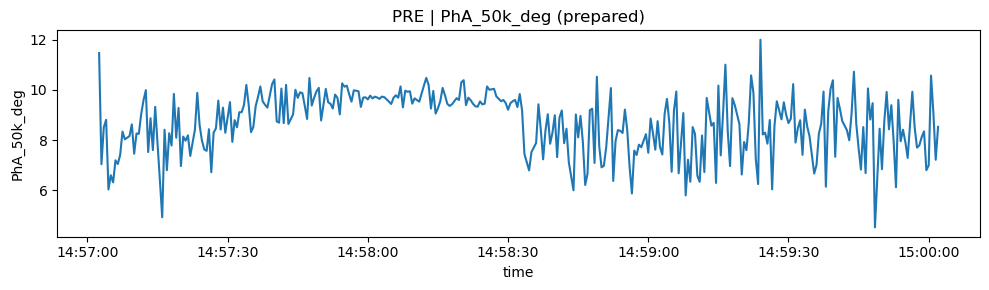

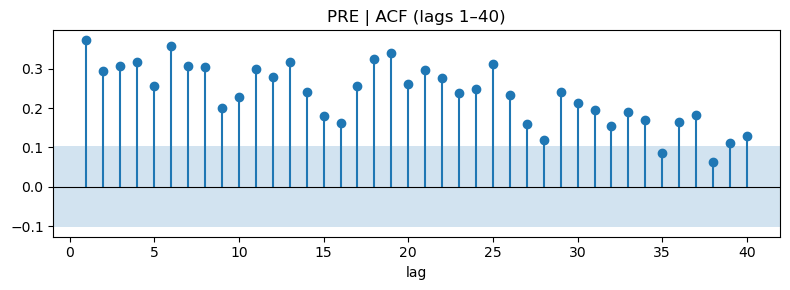

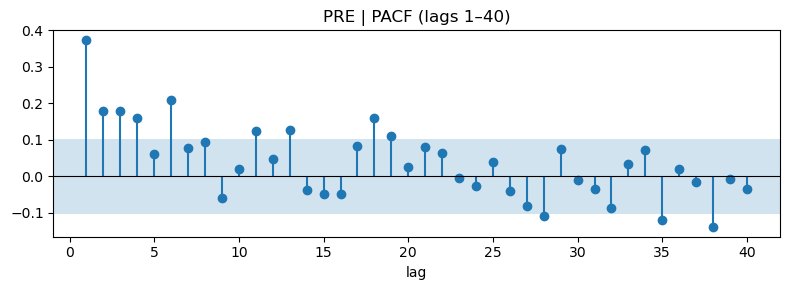

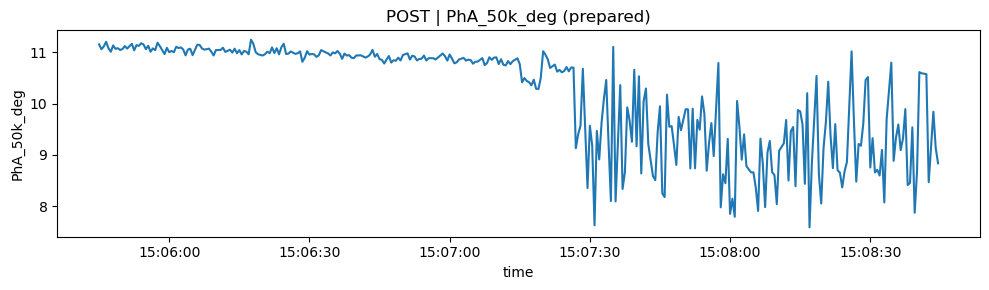

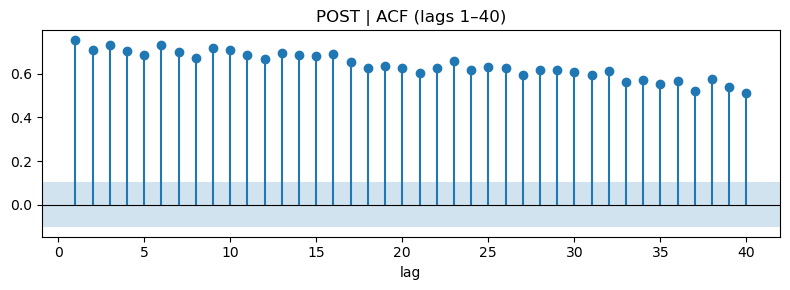

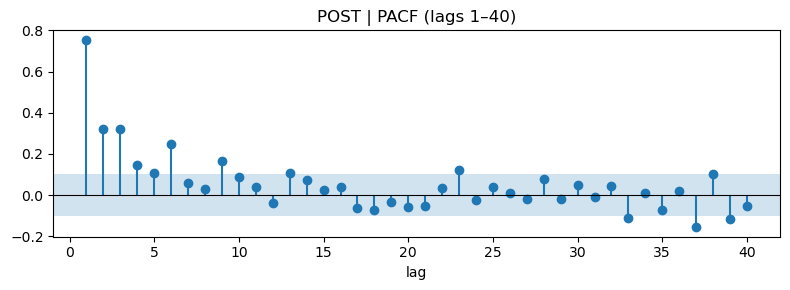

C:\Users\lucas\AppData\Local\Temp\ipykernel_12548\136315516.py:129: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")
C:\Users\lucas\AppData\Local\Temp\ipykernel_12548\136315516.py:129: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(yv, regression="c", nlags="auto")



PRE | stationarity tests
ADF : stat=-1.860 | p=0.3513
KPSS: stat=0.743 | p<0.01

POST | stationarity tests
ADF : stat=-0.968 | p=0.7647
KPSS: stat=2.675 | p<0.01


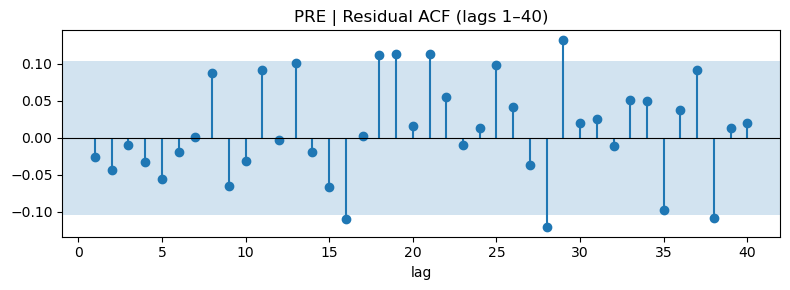

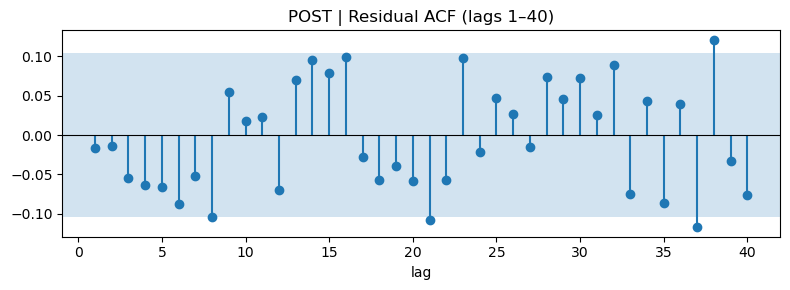

In [ ]:
# =============================================================================
# 1. STOCHASTIC PROCESS ANALYSIS
# =============================================================================

# ACF and PACF
y_pre, info_pre = Stochastic_Process.prep_series(bia_pre)
Stochastic_Process.plot_series_acf_pacf(y_pre, "PRE")
y_post, info_post = Stochastic_Process.prep_series(bia_post)
Stochastic_Process.plot_series_acf_pacf(y_post, "POST")

# Stationarity tests
st_pre = Stochastic_Process.stationarity_tests(y_pre)
Stochastic_Process.print_stationarity(st_pre, "PRE")
st_post = Stochastic_Process.stationarity_tests(y_post)
Stochastic_Process.print_stationarity(st_post, "POST")

# AR modeling
grid_pre = Stochastic_Process.ar_grid_search(y_pre)
grid_post = Stochastic_Process.ar_grid_search(y_post)

# Choose final p by whiteness
chosen_pre = Stochastic_Process.choose_p_by_whiteness(y_pre)
chosen_post = Stochastic_Process.choose_p_by_whiteness(y_post)

# Residual diagnostics
diag_pre = Stochastic_Process.residual_diagnostics(chosen_pre['model'], "PRE")
diag_post = Stochastic_Process.residual_diagnostics(chosen_post['model'], "POST")


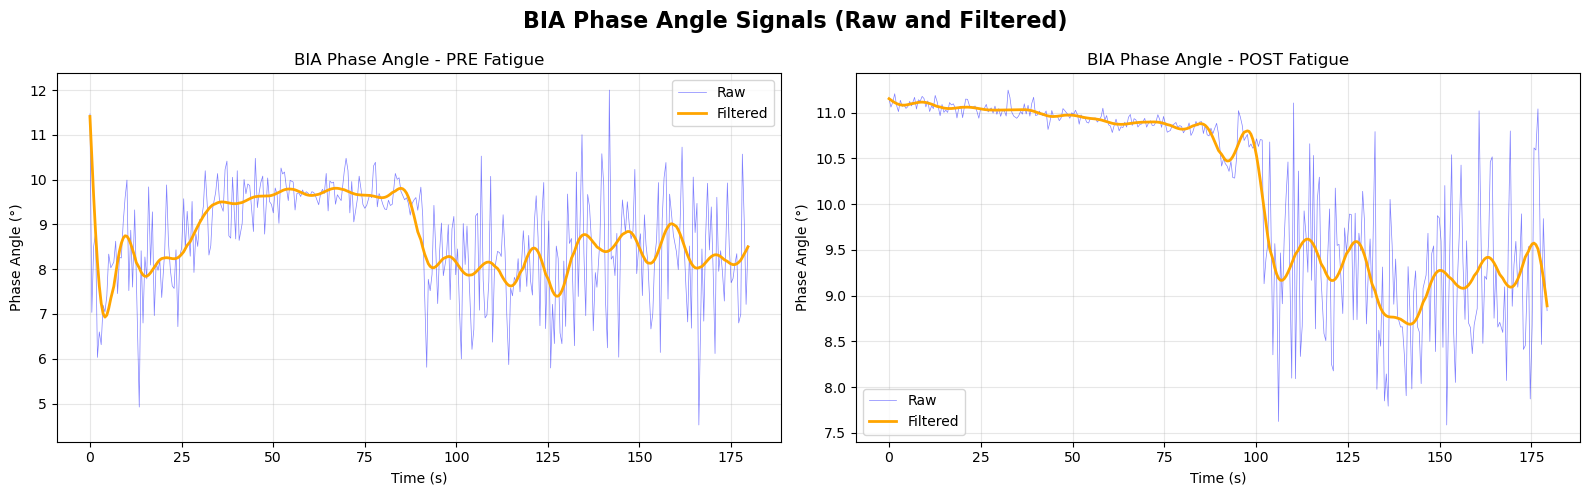

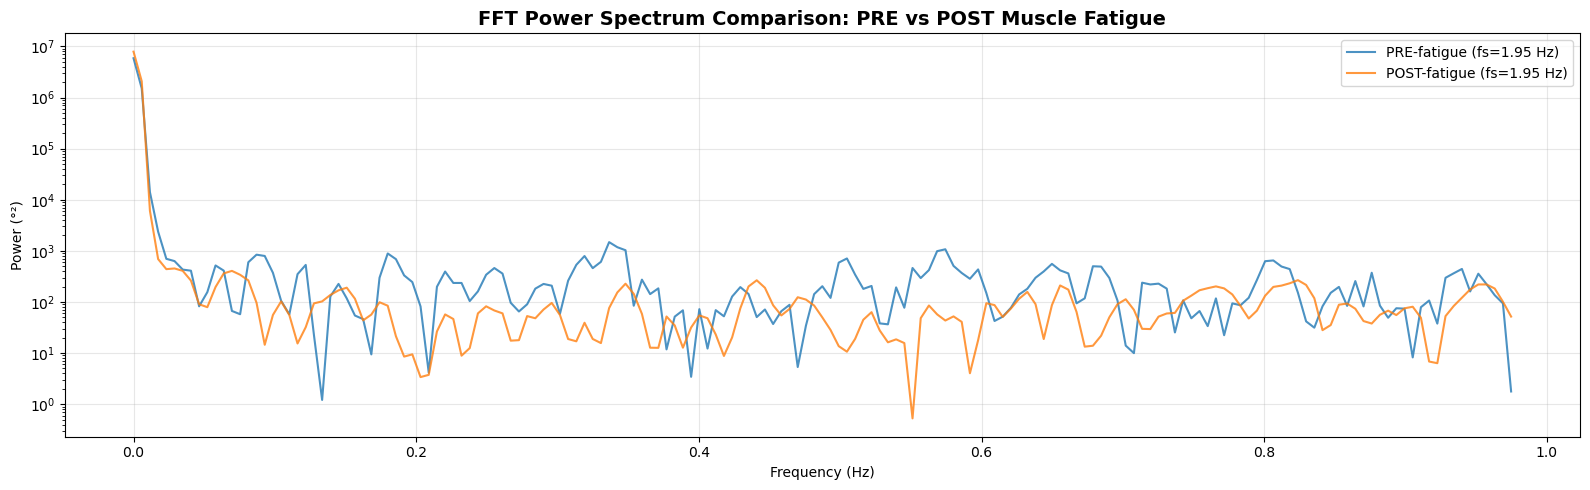

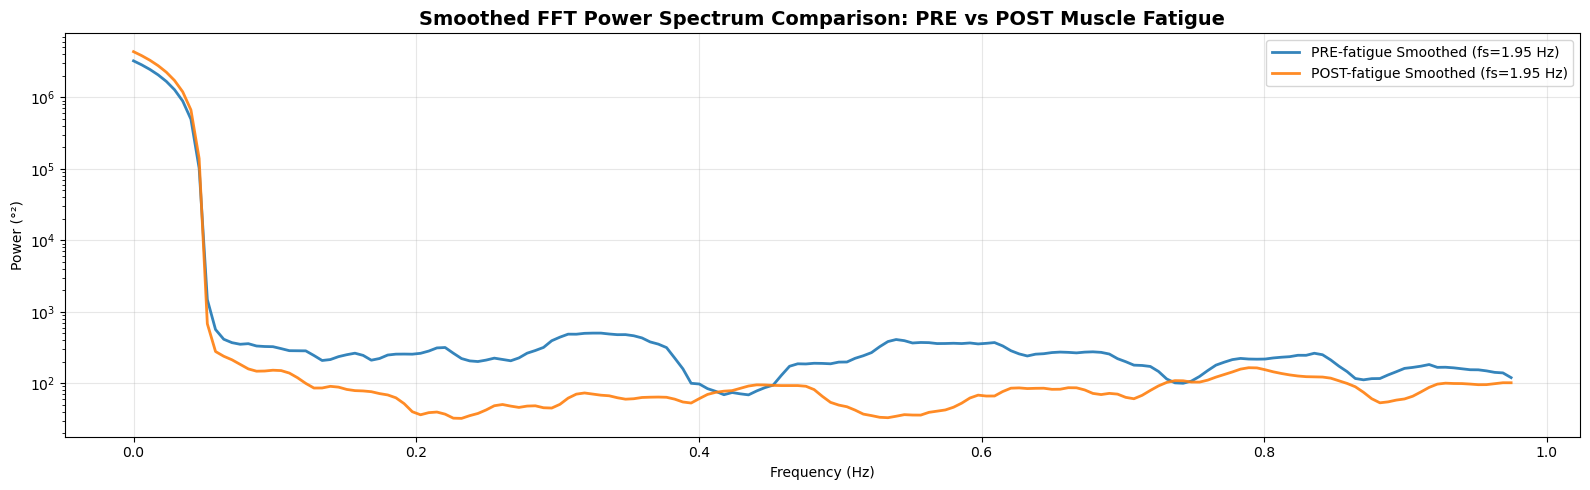

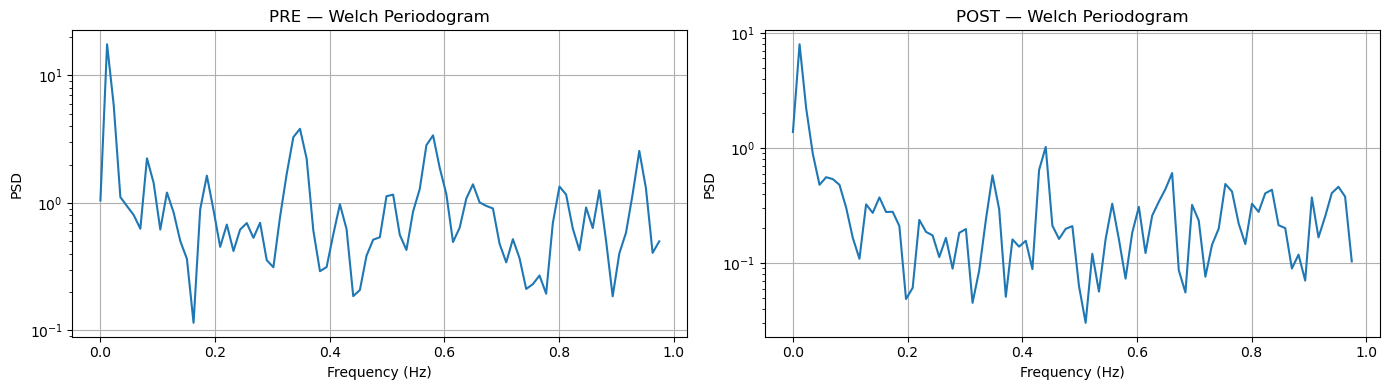

In [ ]:
# =============================================================================
#  2. SPECTRAL ANALYSIS
# =============================================================================

# 1. BIA Phase Angle Signals (Raw and Filtered)

# Apply Butterworth lowpass filter
cutoff_freq = 0.1  # Hz
pha_pre_filtered = SpectralAnalysis.butter_lowpass_filter(pha_pre, cutoff=cutoff_freq, fs=fs_pre_est, order=5)
pha_post_filtered = SpectralAnalysis.butter_lowpass_filter(pha_post, cutoff=cutoff_freq, fs=fs_post_est, order=5)

fig = plt.figure(figsize=(16, 5))
fig.suptitle('BIA Phase Angle Signals (Raw and Filtered)', fontsize=16, fontweight='bold')

# PRE
ax1 = plt.subplot(1, 2, 1)
ax1.plot(t_pre, pha_pre, alpha=0.5, linewidth=0.5, label='Raw', color='blue')
ax1.plot(t_pre, pha_pre_filtered, linewidth=2, label='Filtered', color='orange')
ax1.set_title('BIA Phase Angle - PRE Fatigue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Phase Angle (°)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# POST
ax2 = plt.subplot(1, 2, 2)
ax2.plot(t_post, pha_post, alpha=0.5, linewidth=0.5, label='Raw', color='blue')
ax2.plot(t_post, pha_post_filtered, linewidth=2, label='Filtered', color='orange')
ax2.set_title('BIA Phase Angle - POST Fatigue')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Phase Angle (°)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 2. FFT Power Spectrum Comparison

freqs_fft_pre, power_fft_pre = SpectralAnalysis.compute_fft_power_spectrum(pha_pre, fs_pre_est)
freqs_fft_post, power_fft_post = SpectralAnalysis.compute_fft_power_spectrum(pha_post, fs_post_est)

plt.figure(figsize=(16, 5))
plt.semilogy(freqs_fft_pre, power_fft_pre, label=f'PRE-fatigue (fs={fs_pre_est:.2f} Hz)', linewidth=1.5, alpha=0.8)
plt.semilogy(freqs_fft_post, power_fft_post, label=f'POST-fatigue (fs={fs_post_est:.2f} Hz)', linewidth=1.5, alpha=0.8)
plt.title('FFT Power Spectrum Comparison: PRE vs POST Muscle Fatigue', fontsize=14, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (°²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Smoothed FFT Power Spectrum Comparison

# Apply smoothing using scipy's gaussian filter or simple moving average
from scipy.ndimage import uniform_filter1d

window_size = 15  # Smoothing window
power_fft_pre_smooth = uniform_filter1d(power_fft_pre, size=window_size, mode='nearest')
power_fft_post_smooth = uniform_filter1d(power_fft_post, size=window_size, mode='nearest')

plt.figure(figsize=(16, 5))
plt.semilogy(freqs_fft_pre, power_fft_pre_smooth, label=f'PRE-fatigue Smoothed (fs={fs_pre_est:.2f} Hz)', linewidth=2, alpha=0.9)
plt.semilogy(freqs_fft_post, power_fft_post_smooth, label=f'POST-fatigue Smoothed (fs={fs_post_est:.2f} Hz)', linewidth=2, alpha=0.9)
plt.title('Smoothed FFT Power Spectrum Comparison: PRE vs POST Muscle Fatigue', fontsize=14, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (°²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Welch Periodogram (Individual)


freqs_pre, psd_pre = welch(pha_pre, fs=fs_pre_est, nperseg=min(256, len(pha_pre)//2))
freqs_post, psd_post = welch(pha_post, fs=fs_post_est, nperseg=min(256, len(pha_post)//2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.semilogy(freqs_pre, psd_pre)
ax1.set_title('PRE — Welch Periodogram')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('PSD')
ax1.grid(True)

ax2.semilogy(freqs_post, psd_post)
ax2.set_title('POST — Welch Periodogram')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD')
ax2.grid(True)
plt.tight_layout()
plt.show()

# 5. Dominant Frequency


idx_dom_pre = np.argmax(psd_pre)
f_dom_pre = freqs_pre[idx_dom_pre]
P_dom_pre = psd_pre[idx_dom_pre]

idx_dom_post = np.argmax(psd_post)
f_dom_post = freqs_post[idx_dom_post]
P_dom_post = psd_post[idx_dom_post]


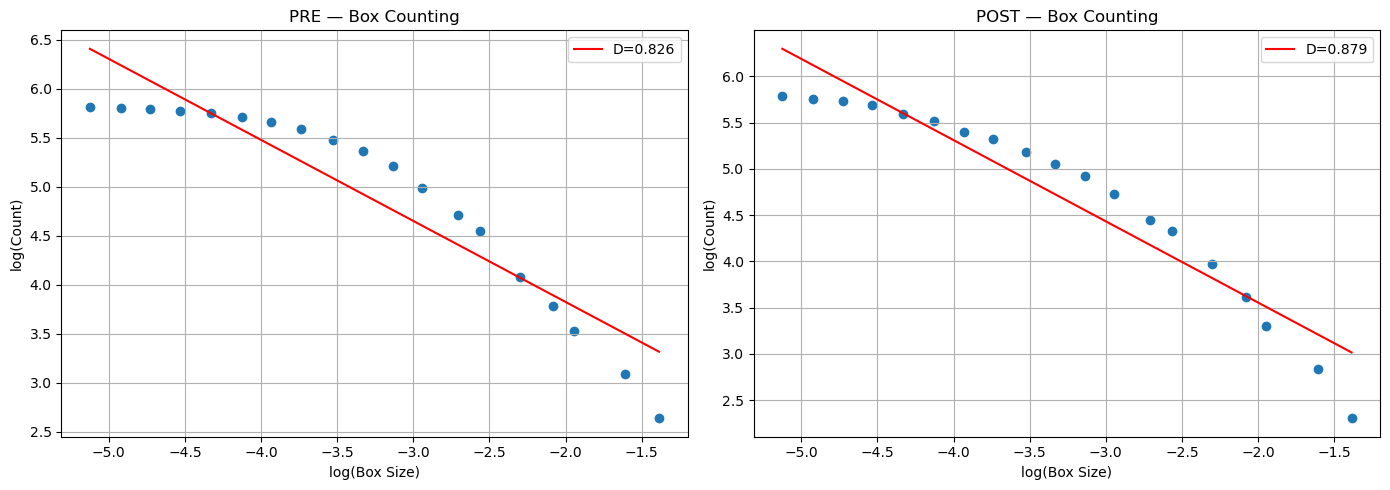

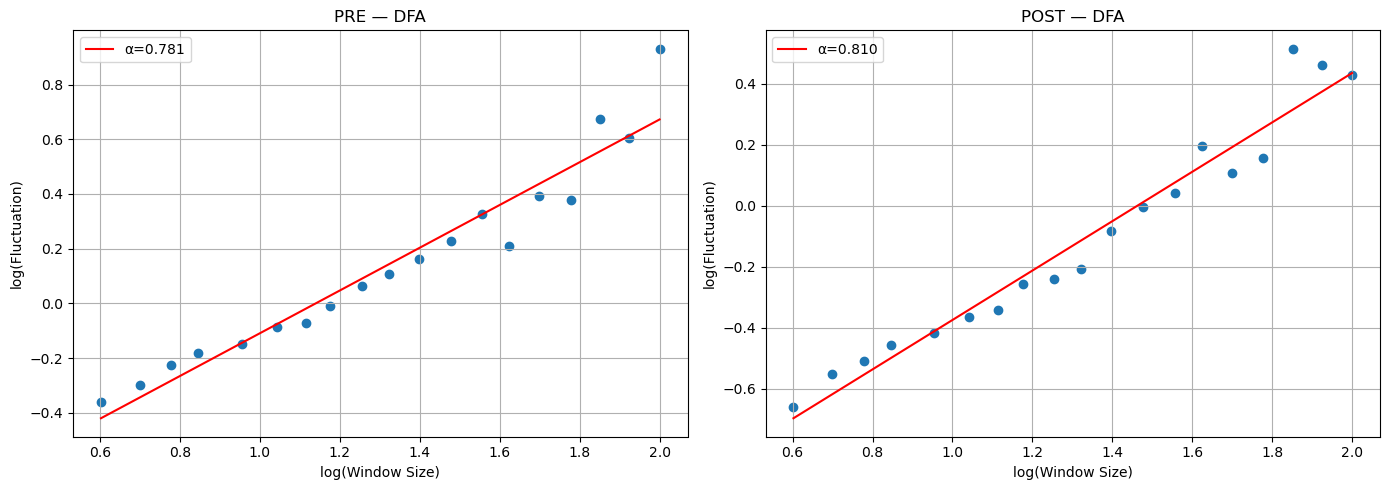

In [ ]:
# =============================================================================
# 3. FRACTAL ANALYSIS
# =============================================================================

# Box Counting Dimension
dim_pre, box_sizes_pre, box_counts_pre = fractal_analysis.fractal_dimension_boxcount(pha_pre)
dim_post, box_sizes_post, box_counts_post = fractal_analysis.fractal_dimension_boxcount(pha_post)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(np.log(box_sizes_pre), np.log(box_counts_pre))
coeffs_pre = np.polyfit(np.log(box_sizes_pre), np.log(box_counts_pre), 1)
ax1.plot(np.log(box_sizes_pre), np.polyval(coeffs_pre, np.log(box_sizes_pre)), 'r-', label=f'D={dim_pre:.3f}')
ax1.set_title('PRE — Box Counting')
ax1.set_xlabel('log(Box Size)')
ax1.set_ylabel('log(Count)')
ax1.legend()
ax1.grid(True)

ax2.scatter(np.log(box_sizes_post), np.log(box_counts_post))
coeffs_post = np.polyfit(np.log(box_sizes_post), np.log(box_counts_post), 1)
ax2.plot(np.log(box_sizes_post), np.polyval(coeffs_post, np.log(box_sizes_post)), 'r-', label=f'D={dim_post:.3f}')
ax2.set_title('POST — Box Counting')
ax2.set_xlabel('log(Box Size)')
ax2.set_ylabel('log(Count)')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# DFA Analysis
alpha_pre, scales_pre, fluct_pre = fractal_analysis.dfa_analysis(pha_pre, min_scale=4, max_scale=100)
alpha_post, scales_post, fluct_post = fractal_analysis.dfa_analysis(pha_post, min_scale=4, max_scale=100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(np.log10(scales_pre), np.log10(fluct_pre))
coeffs_dfa_pre = np.polyfit(np.log10(scales_pre), np.log10(fluct_pre), 1)
ax1.plot(np.log10(scales_pre), np.polyval(coeffs_dfa_pre, np.log10(scales_pre)), 'r-', label=f'α={alpha_pre:.3f}')
ax1.set_title('PRE — DFA')
ax1.set_xlabel('log(Window Size)')
ax1.set_ylabel('log(Fluctuation)')
ax1.legend()
ax1.grid(True)

ax2.scatter(np.log10(scales_post), np.log10(fluct_post))
coeffs_dfa_post = np.polyfit(np.log10(scales_post), np.log10(fluct_post), 1)
ax2.plot(np.log10(scales_post), np.polyval(coeffs_dfa_post, np.log10(scales_post)), 'r-', label=f'α={alpha_post:.3f}')
ax2.set_title('POST — DFA')
ax2.set_xlabel('log(Window Size)')
ax2.set_ylabel('log(Fluctuation)')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

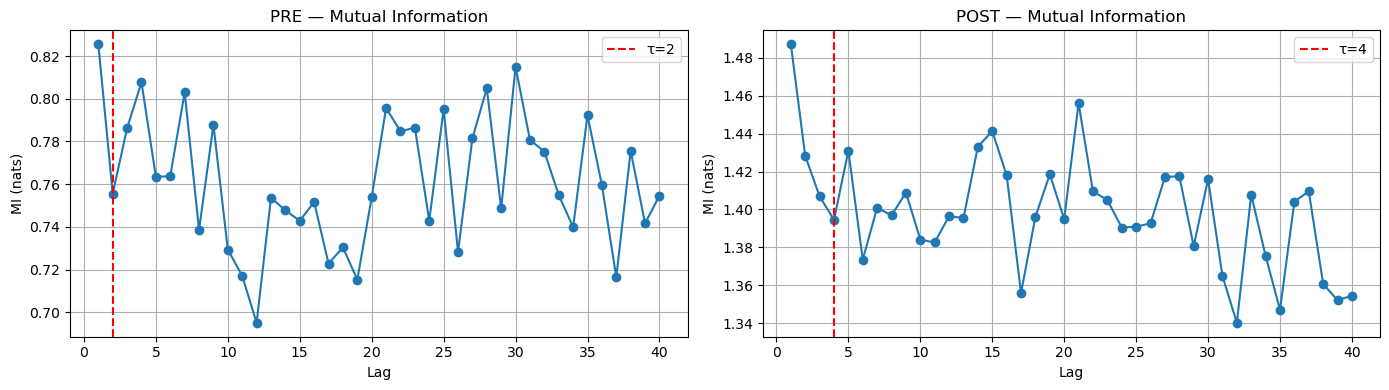

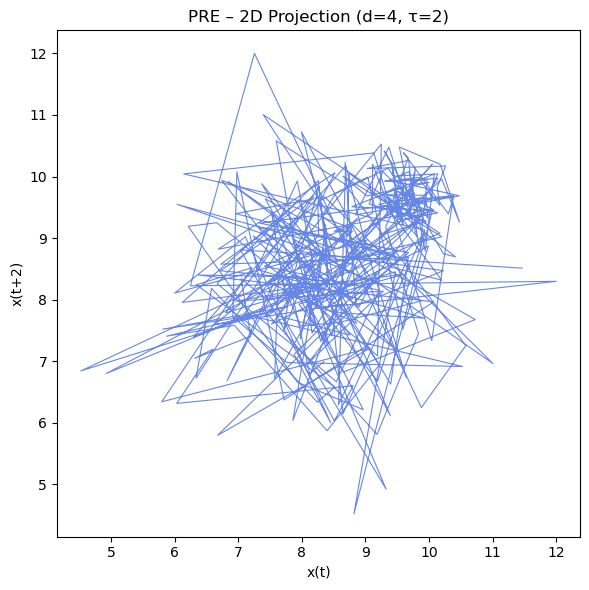

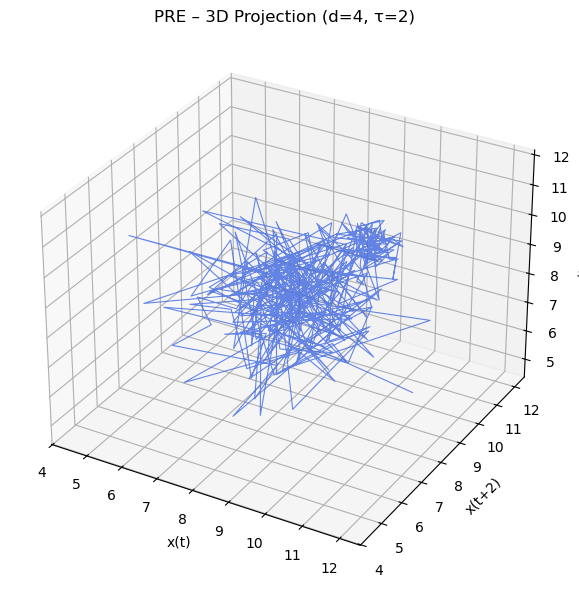

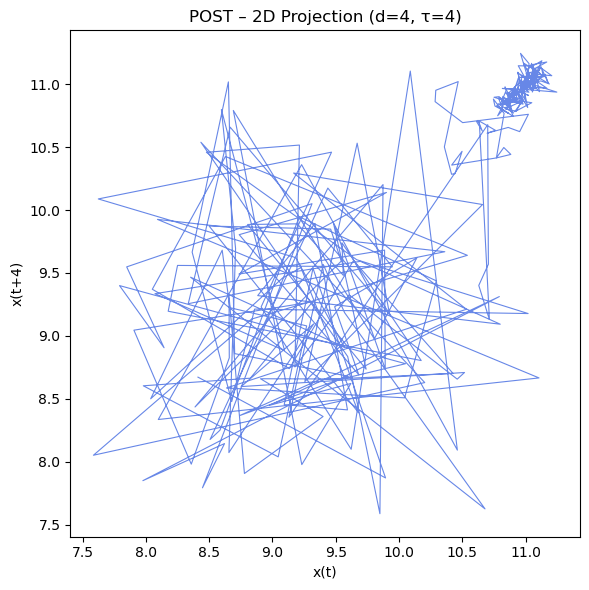

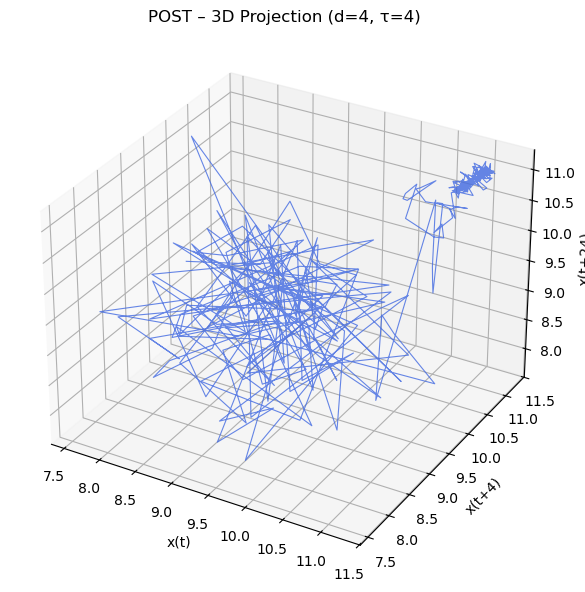


SURROGATE DATA ANALYSIS - PSD PRESERVATION CHECK

Generating surrogate for PRE...
Checking PSD preservation for PRE:


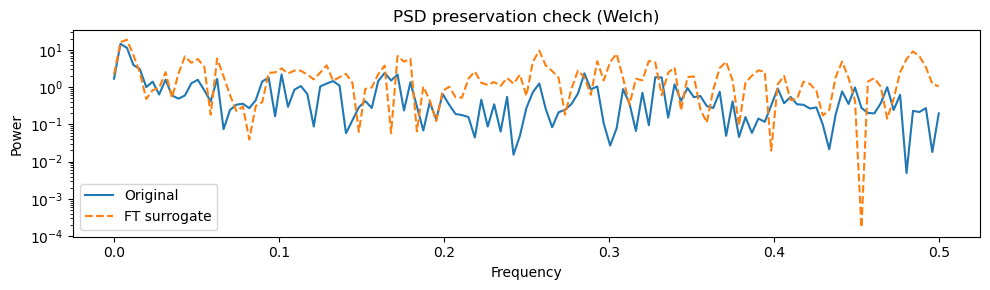

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 4.648e-16
  max_rel : 1.808e-15

PRE - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 4.648e-16
  Max relative error: 1.808e-15

--------------------------------------------------------------------------------

Generating surrogate for POST...
Checking PSD preservation for POST:


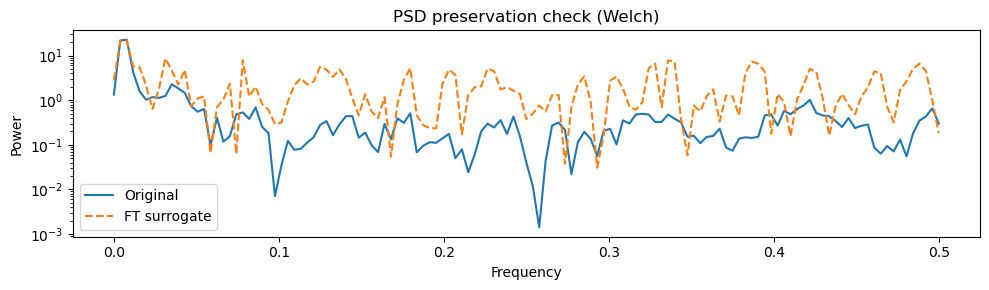

FFT amplitude preservation test
  allclose: True
  rel_RMSE: 1.358e-04
  max_rel : 1.765e-03

POST - FFT Amplitude Preservation:
  Test passed: True
  Relative RMSE: 1.358e-04
  Max relative error: 1.765e-03

→ Surrogates preserve power spectrum (linear properties)
→ Phase randomization destroys nonlinear structure


In [ ]:
# =============================================================================
# 4. NON-LINEAR ANALYSIS
# =============================================================================
# Mutual Information
MAX_LAG = 40
lags_pre, mi_pre = NonLinearAnalysis.compute_mi_lags(pha_pre, max_lag=MAX_LAG, bins=32)
tau_pre_mi = NonLinearAnalysis.first_local_minimum(lags_pre, mi_pre) if lags_pre.size else None

lags_post, mi_post = NonLinearAnalysis.compute_mi_lags(pha_post, max_lag=MAX_LAG, bins=32)
tau_post_mi = NonLinearAnalysis.first_local_minimum(lags_post, mi_post) if lags_post.size else None

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(lags_pre, mi_pre, '-o')
if tau_pre_mi:
    ax1.axvline(tau_pre_mi, color='red', linestyle='--', label=f'τ={tau_pre_mi}')
ax1.set_title('PRE — Mutual Information')
ax1.set_xlabel('Lag')
ax1.set_ylabel('MI (nats)')
ax1.grid(True)
ax1.legend()

ax2.plot(lags_post, mi_post, '-o')
if tau_post_mi:
    ax2.axvline(tau_post_mi, color='red', linestyle='--', label=f'τ={tau_post_mi}')
ax2.set_title('POST — Mutual Information')
ax2.set_xlabel('Lag')
ax2.set_ylabel('MI (nats)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# False Nearest Neighbors
tau_use_pre = tau_pre_mi if tau_pre_mi else 3
tau_use_post = tau_post_mi if tau_post_mi else 4

fnn_pre = NonLinearAnalysis.false_nearest_neighbors(pha_pre, max_dim=10, tau=tau_use_pre)
optimal_d_pre = np.argmin(fnn_pre) + 1


fnn_post = NonLinearAnalysis.false_nearest_neighbors(pha_post, max_dim=10, tau=tau_use_post)
optimal_d_post = np.argmin(fnn_post) + 1


# Phase Space Reconstruction
NonLinearAnalysis.plot_phase_space(pha_pre, tau=tau_use_pre, d=optimal_d_pre, name="PRE")
NonLinearAnalysis.plot_phase_space(pha_post, tau=tau_use_post, d=optimal_d_post, name="POST")

# Detrending & Standardization
pha_pre_detrend = NonLinearAnalysis.detrend_polynomial(pha_pre, order=3)
pha_post_detrend = NonLinearAnalysis.detrend_polynomial(pha_post, order=3)

pha_pre_std = (pha_pre_detrend - np.mean(pha_pre_detrend)) / np.std(pha_pre_detrend)
pha_post_std = (pha_post_detrend - np.mean(pha_post_detrend)) / np.std(pha_post_detrend)

# Sample Entropy
m, r = 3, 0.20
sampen_pre = NonLinearAnalysis.sample_entropy(pha_pre_std, m=m, r=r)
sampen_post = NonLinearAnalysis.sample_entropy(pha_post_std, m=m, r=r)

# Surrogate Data Analysis - PSD Preservation Check
print("\n" + "="*80)
print("SURROGATE DATA ANALYSIS - PSD PRESERVATION CHECK")
print("="*80)

# Generate phase-randomized surrogates for PRE
print("\nGenerating surrogate for PRE...")
surr_pre = NonLinearAnalysis.phase_randomized_surrogate(pha_pre_std, random_state=42)
print("Checking PSD preservation for PRE:")
NonLinearAnalysis.check_psd(pha_pre_std, surr_pre, nperseg=min(256, len(pha_pre_std)))

# FFT amplitude preservation test
ok_pre, rmse_pre, max_rel_pre = NonLinearAnalysis.test_fft_amplitude_preservation(pha_pre_std, surr_pre)
print(f"\nPRE - FFT Amplitude Preservation:")
print(f"  Test passed: {ok_pre}")
print(f"  Relative RMSE: {rmse_pre:.3e}")
print(f"  Max relative error: {max_rel_pre:.3e}")

# Generate phase-randomized surrogates for POST
print("\n" + "-"*80)
print("\nGenerating surrogate for POST...")
surr_post = NonLinearAnalysis.phase_randomized_surrogate(pha_post_std, random_state=42)
print("Checking PSD preservation for POST:")
NonLinearAnalysis.check_psd(pha_post_std, surr_post, nperseg=min(256, len(pha_post_std)))

# FFT amplitude preservation test
ok_post, rmse_post, max_rel_post = NonLinearAnalysis.test_fft_amplitude_preservation(pha_post_std, surr_post)
print(f"\nPOST - FFT Amplitude Preservation:")
print(f"  Test passed: {ok_post}")
print(f"  Relative RMSE: {rmse_post:.3e}")
print(f"  Max relative error: {max_rel_post:.3e}")

print("\n" + "="*80)
print("→ Surrogates preserve power spectrum (linear properties)")
print("→ Phase randomization destroys nonlinear structure")
print("="*80)

